# postp basics

Relevant for idealized simulations for now

In [2]:
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import crocosi.postp as pp
import crocosi.plot as cplt

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=4)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.68:54132 Dashboard: http://10.148.1.68:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## compare energy time series

In [4]:
root_path = '/home/c11-data/Test_aponte/jetn/'


weights = [.5, .6, .7, .8, .9]
#weights = [.5, .6, .7, .8]
runs = ['jet_cfg1_wp{}_4km_0a1000j/'.format(int(10*w)) for w in weights]
print(runs)

R = [pp.Run(root_path+r, open_nc=['surf']) for r in runs]

# adjust time
for r in R:
    r['surf'] = r['surf'].assign_coords(time=r['surf'].time_instant.chunk({'time':None}))

['jet_cfg1_wp5_4km_0a1000j/', 'jet_cfg1_wp6_4km_0a1000j/', 'jet_cfg1_wp7_4km_0a1000j/', 'jet_cfg1_wp8_4km_0a1000j/', 'jet_cfg1_wp9_4km_0a1000j/']


Text(0.5, 1.0, 'kinetic energy')

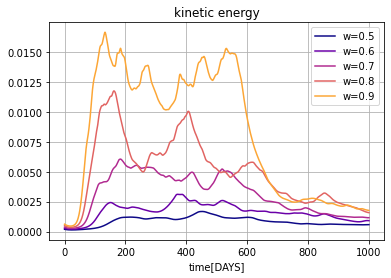

In [20]:
colors = cplt.get_cmap_colors(len(R))

fig, ax = plt.subplots(1, 1) #, figsize=(4,3))
for r, w, c in zip(R, weights, colors):
    r.stats['KINETIC_ENRG'].plot(ax=ax, label='w={}'.format(w), color=c)
ax.legend()
ax.grid()
ax.set_title('kinetic energy')

---

## snapshots at day 500

In [6]:
t = 500.
ds = xr.concat([r['surf'].sel(time=t) for r in R], 
               dim=pd.Series(weights).rename('weight')).persist()

In [7]:
# add relative vorticity

r = R[0]
u, v = ds['u'], ds['v']
ds['zeta'] = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

f_rho = r['grid'].f + r['grid'].x_rho*0.
ds = ds.assign_coords(f_zeta=r.xgrid.interp(r.xgrid.interp(f_rho, 'eta'), 'xi'))

ds['zeta_over_f'] = ds.zeta/ds.f_zeta

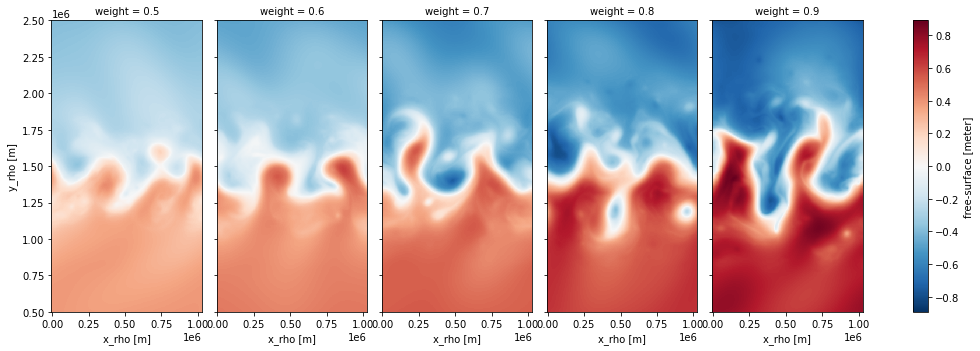

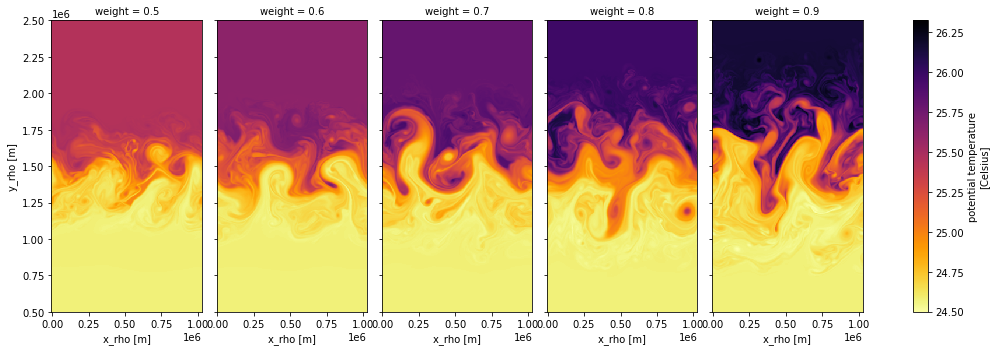

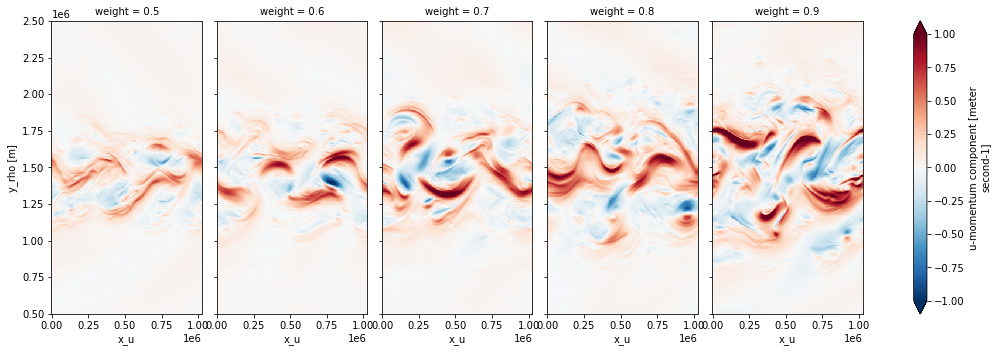

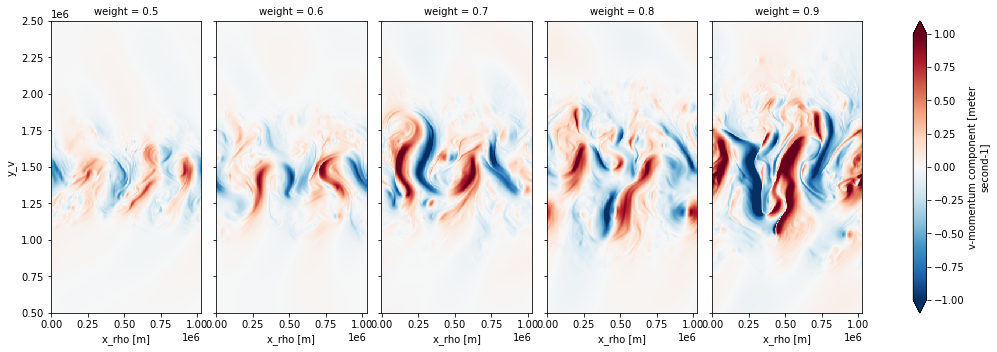

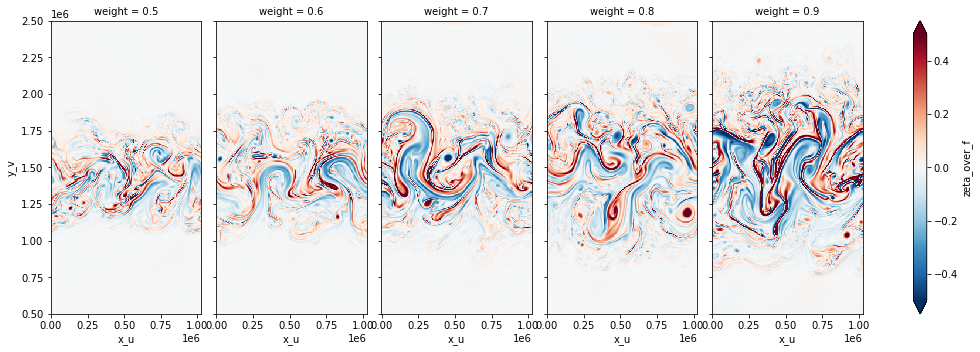

In [9]:
V = ['ssh', 'T', 'u', 'v', 'zeta_over_f']

vlims = {'ssh': {}, 'T': {'cmap': 'inferno_r'}, 
         'u': {'vmin':-1.,'vmax':1., 'cmap': 'RdBu_r'}, 
         'v': {'vmin':-1.,'vmax':1., 'cmap': 'RdBu_r'}, 
         'zeta_over_f': {'vmin':-.5,'vmax':.5, 'cmap': 'RdBu_r'}}

hmap_kwargs = {'col': 'weight', 'col_wrap': len(R), 
               'subplot_kws': {'aspect':'equal'},
               'aspect':.5, 'figsize':(15,5),
               'ylim': [500*1e3, 2500*1e3]}

for v in V:
    hdl = (ds[v].plot(**hmap_kwargs, **vlims[v])
           )

---

## time and zonally averaged statistics

In [28]:
_D = []
for r in R:
    
    ds = r['surf']
    u, v = ds['u'], ds['v']
    
    # add relative vorticity
    ds['zeta'] = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))
    f_rho = r['grid'].f + r['grid'].x_rho*0.
    ds = ds.assign_coords(f_zeta=r.xgrid.interp(r.xgrid.interp(f_rho, 'eta'), 'xi'))
    ds['zeta_over_f'] = ds.zeta/ds.f_zeta
    
    _D.append(ds.std(['time', 'x_rho', 'x_u']))
    
ds_std = (xr.concat(_D, dim=pd.Series(weights).rename('weight'))
         ).persist()

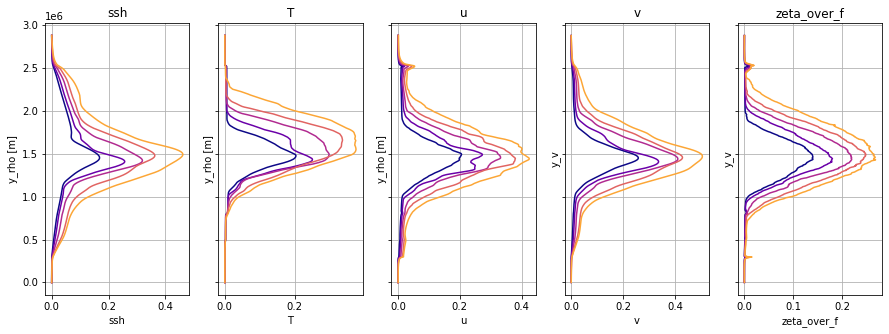

In [29]:
fig, axs = plt.subplots(1, len(V), figsize=(15, 5), sharey=True)
for v, ax in zip(V, axs):
    ydim = next((x for x in ds_std[v].dims if x[0]=='y'), None) 
    for w, c in zip(weights, colors):
        ds_std[v].sel(weight=w).plot(ax=ax, y=ydim, c=c, label='w={}'.format(w))
        ax.grid()
        ax.set_title(v)

---

In [30]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
